/tmp/ipykernel_1162778/704522329.py:13: WavFileWarning: Reached EOF prematurely; finished at 403245 bytes, expected 4294967303 bytes from header.
  sr, x = wavfile.read(path)
/tmp/ipykernel_1162778/704522329.py:13: WavFileWarning: Reached EOF prematurely; finished at 376845 bytes, expected 4294967303 bytes from header.
  sr, x = wavfile.read(path)


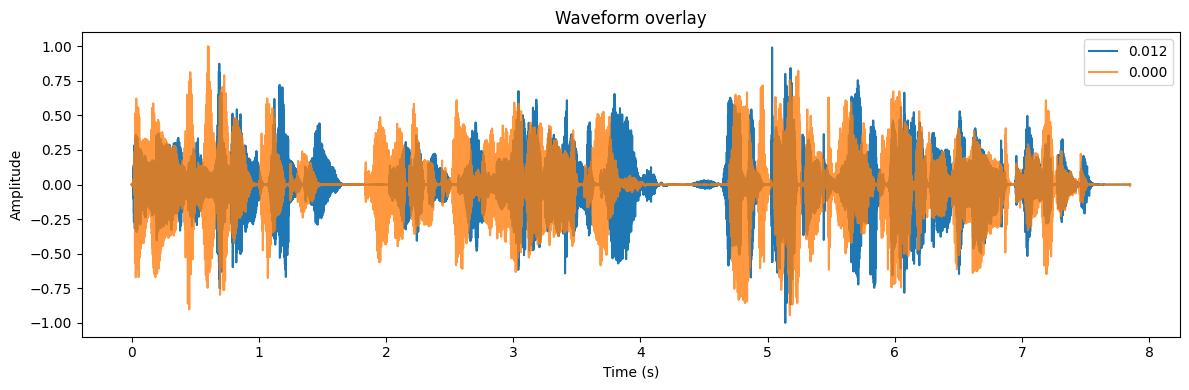

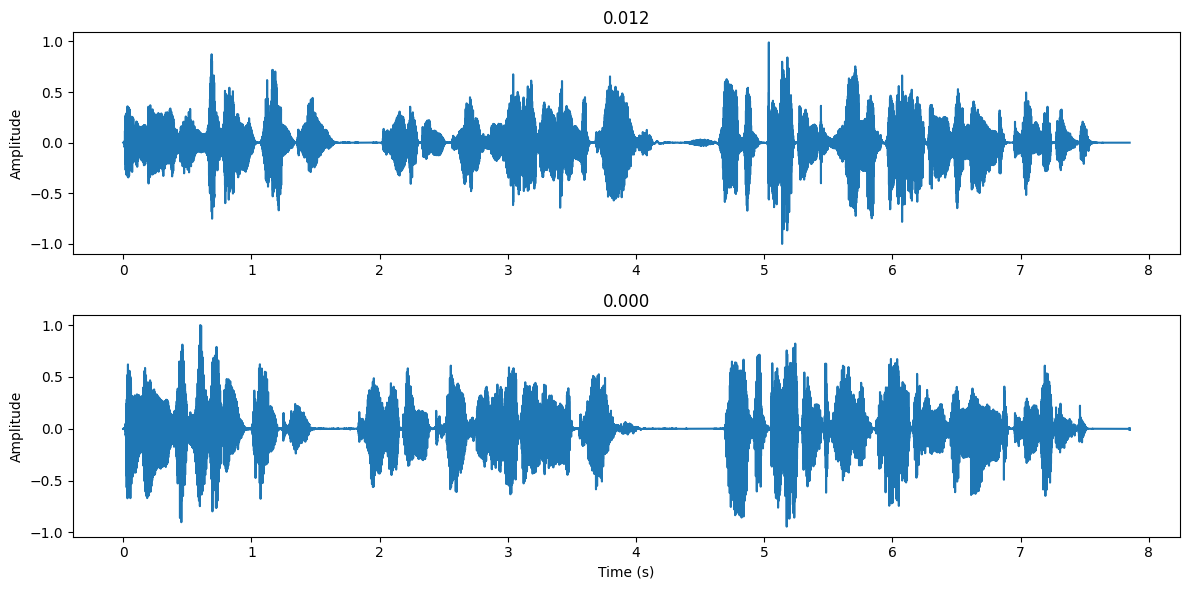

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read_wav(path):
    # 优先用 soundfile（更通用），没有就回退到 scipy
    try:
        import soundfile as sf
        x, sr = sf.read(path, always_2d=True)   # [T, C]
        x = x.mean(axis=1)                      # 转单声道
        return x.astype(np.float32), sr
    except Exception:
        from scipy.io import wavfile
        sr, x = wavfile.read(path)
        x = x.astype(np.float32)
        if x.ndim == 2:
            x = x.mean(axis=1)
        # 如果是 int PCM，归一化到 [-1, 1]
        if np.max(np.abs(x)) > 1.5:
            x = x / np.max(np.abs(x))
        return x, sr

def resample_to(x, sr_from, sr_to):
    if sr_from == sr_to:
        return x
    from scipy.signal import resample_poly
    # 用有理近似做 resample_poly
    from fractions import Fraction
    frac = Fraction(sr_to, sr_from).limit_denominator(1000)
    return resample_poly(x, frac.numerator, frac.denominator).astype(np.float32)

def plot_waveform_compare(wav1, wav2, title1="wav1", title2="wav2",
                          overlay_seconds=None, normalize=True):
    x1, sr1 = read_wav(wav1)
    x2, sr2 = read_wav(wav2)
    x2 = resample_to(x2, sr2, sr1)

    if normalize:
        m1 = np.max(np.abs(x1)) + 1e-9
        m2 = np.max(np.abs(x2)) + 1e-9
        x1 = x1 / m1
        x2 = x2 / m2

    n = min(len(x1), len(x2))
    x1 = x1[:n]
    x2 = x2[:n]

    if overlay_seconds is not None:
        n_show = min(n, int(overlay_seconds * sr1))
        x1s, x2s = x1[:n_show], x2[:n_show]
    else:
        x1s, x2s = x1, x2

    t = np.arange(len(x1s)) / sr1

    # 1) 同轴叠加（看整体差异）
    plt.figure(figsize=(12, 4))
    plt.plot(t, x1s, label=title1)
    plt.plot(t, x2s, label=title2, alpha=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform overlay")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) 上下分图（避免遮挡，便于细看）
    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t, x1s)
    ax1.set_title(title1)
    ax1.set_ylabel("Amplitude")

    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(t, x2s)
    ax2.set_title(title2)
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# wav_12_path = "/data/home/zdhs0047/zdhs0047_src_data/zengfanshuo/EmoVoice/ckpt/tts_decode_test_rp_seed_greedy_kaiyuan_CE_and_Align_epoch-40-align-0.012-new10/pred_audio/neutral_prompt_speech/gpt4o_1268_happy_verse.wav"
# war_00_Path = "/data/home/zdhs0047/zdhs0047_src_data/zengfanshuo/EmoVoice/ckpt/tts_decode_test_rp_seed_greedy_kaiyuan_CE_and_Align_epoch-40-align/pred_audio/neutral_prompt_speech/gpt4o_1268_happy_verse.wav"
happy_path = "/data/home/zdhs0047/zdhs0047_src_data/zengfanshuo/EmoVoice/gene_trip_data/triplets_out/wav/happy/000000_ballad.wav"
neutral_path = "/data/home/zdhs0047/zdhs0047_src_data/zengfanshuo/EmoVoice/gene_trip_data/triplets_out/wav/neutral/000000_ballad.wav"
# 用法示例：
plot_waveform_compare(happy_path, neutral_path, title1="0.012", title2="0.000", overlay_seconds=10, normalize=True)
